#   Finite-volume solution of the advection equation
In this exercise we solve numerically the *advection equation*.  We model the dynamics of a conserved one-dimensional fluid with density $u$ that is moving to the left with a constant velocity $c$.  The equation to solve is
$$
\frac{\partial u}{\partial t} = -c\frac{\partial u}{\partial x}.
$$
For conservative problems like this it is frequent to use the *Finite Volume* method where one divides his domain in finite cells $(x_{i-1/2}, x_{i+1/2})$.  Then we have approximate densities for each cell $U_i$ and fluxes $F_{i+1/2}$ at the boundaries.  A naive way to calculate fluxes at $x_{i+1/2}$ is to interpolate the densities within the two neighboring cells:
$$
    F_{i+1/2} = \frac{1}{2} c (U_i + U_{i+1}).
$$
But we will see that this is problematic.


## Implementation in pure python
Our first implementation is in pure python and is slow and not parallel.

In [1]:
# Import statements.
%matplotlib inline
%load_ext autoreload
%autoreload 2
import importlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Build the mesh.  First the boundaries and then the centers of the cells
n = 500000
l = 1.0
xb = np.linspace(0, l, n + 1)
xc = 0.5 * (xb[1:] + xb[:-1])
dx = xb[1] - xb[0]

In [3]:
# Velocity of the fluid
c = 1.0

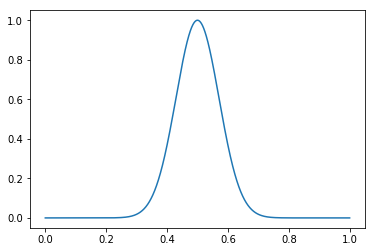

In [4]:
# Set initial condition
width = 0.1
u0 = np.exp(-(xc-l/2)**2/width**2)
plt.plot(xc, u0)

In [5]:
def deriv_u_interp(u):
    """We define now a function that, given the densities, returns their time derivatives"""
    # Compute fluxes
    # We assume here that u has been extended with ghost cells
    F = 0.5 * c * (u[1:]+u[:-1])
    return -np.diff(F) / dx

For the time marching we use here the simplest possible scheme: explicit or forward Euler.  In this scheme the solution at a time $t+\Delta t$ is calculated from the solution at $t$ as 
$$
u(t + \Delta t) = u(t) + u'(t) \Delta t
$$
Note that much better time-integration schemes exist, with a higher order of convergence. 

In [6]:
# Fix the time discretization using the Courant-Friderichs-Levy (CFL) criterium
dt = .2 * dx / c
m = 1000

In [7]:
# Allocate space to save the solution
# In Python and C/C++ memory strides are shorter for later dimensions.  In Fortran it's the opposite.
u = np.zeros((m, n + 2))
# Here u[i, j] and u[i, j+1] are adjacent in memory.  This organization is cache-friendly.
# We use n + 2 cells to allow ghost cells for the boundary conditions.

In [8]:
u[0, 1:-1] = u0

In [9]:
for j in range(1, m):
    # Periodic b.c.
    u[j - 1, 0] = u[j - 1, n]
    u[j - 1, n + 1] = u[j - 1, 0]
    
    u[j, 1:-1] = u[j - 1, 1:-1] + dt * deriv_u_interp(u[j - 1, :])

Already in the 100 initial timesteps we see problems

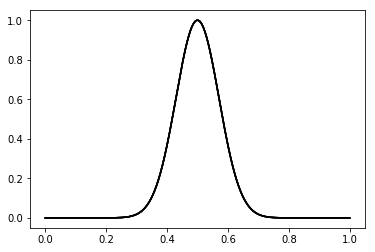

In [10]:
for j in range(0, 100, 10):
    plt.plot(xc, u[j, 1:-1], c='k', alpha=0.5)

Some oscillations appear around timestep 250

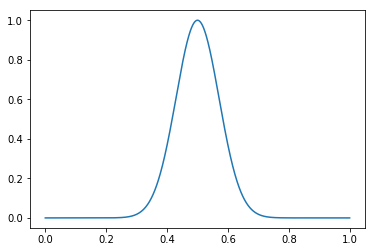

In [11]:
plt.plot(xc, u[250, 1:-1])

Even more oscillations at timestep 300

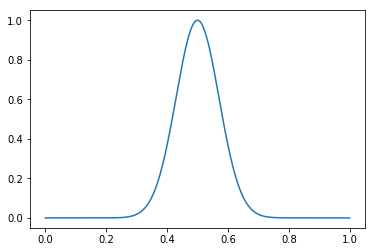

In [12]:
plt.plot(xc, u[300, 1:-1])

These oscillations are a well-known problem of our discretization.  It's better if we assume that the fluxes are given only by the *upwind* cell.  In our case $c>0$ so the upwiind cell at $x_{i+1/2}$ is always cell $i$.

In [13]:
def deriv_u_upwind(u):
    """We define now a function that, given the densities, returns their time derivatives"""
    # Compute fluxes
    # We assume here that u has been extended with ghost cells
    F = c * u[:-1]
    return -np.diff(F) / dx

In [14]:
%%time
for j in range(1, m):
    # Periodic b.c.
    u[j - 1, 0] = u[j - 1, n]
    u[j - 1, n + 1] = u[j - 1, 0]
    
    u[j, 1:-1] = u[j - 1, 1:-1] + dt * deriv_u_upwind(u[j - 1, :])

CPU times: user 3.33 s, sys: 15.4 ms, total: 3.35 s
Wall time: 3.4 s


With the upwind scheme the oscillations dissapear but the solution is too diffusive (the neglected second order term adds a diffusion).  The solution is to use higher-order terms but to avoid the oscillations seen above one needs a *flux limiter.*  Unfortunately we do not have time here to discuss this.

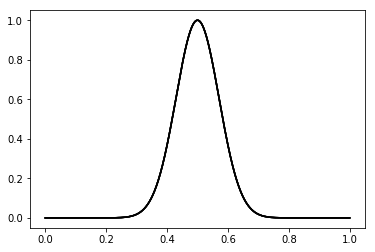

In [15]:
for j in range(0, 500, 50):
    plt.plot(xc, u[j, 1:-1], c='k', alpha=0.5)

## Call Fortran through f2py
We now implement the same algorithm but using Fortran.  It's easy to combine Fortran and Python thanks to the f2py utility.  We can do everything within this notebook but typically one would use separate files and edit them with a real syntax-aware editor (emacs, vim, SublimeText, Atom...).

In [16]:
%%file advection.f90
module cmp
contains
  
  subroutine deriv_u_upwind(dx, c, u, du)
    double precision, intent(in) :: c, dx, u(:)
    double precision, intent(out) :: du(:)
    
    double precision :: f(size(du) + 1)
  
    f(:) = c * u(1: size(u) - 1)
    du(:) = -(f(2: size(f)) - f(1: size(f) - 1)) / dx
  end subroutine deriv_u_upwind
  
  subroutine forward_euler_serial(dx, dt, c, u0, u, n, m)
    ! Note the inverted order of dimensions
    double precision, intent(in) :: dx, dt, c, u0(n)
    double precision, intent(inout) :: u(n + 2, m)
    integer, intent(in) :: n, m

    !f2py integer intent(hide), depend(u) :: n=size(u,1)-2, m=size(u,2)

    double precision :: du(n)
  
    u(2:size(u, 1) - 1, 1) = u0
    do j = 2, m
       ! Periodic b.c.
       u(1, j - 1) = u(size(u, 1) - 1, j - 1)
       u(size(u, 1), j - 1) = u(1, j - 1)

       call deriv_u_upwind(dx, c, u(:, j - 1), du)
       do i=2, size(u, 1) - 1
          u(i, j) = u(i, j - 1) + dt * du(j - 1)
       end do
    end do
  end subroutine forward_euler_serial

  subroutine forward_euler_omp(dx, dt, c, u0, u, n, m)
    ! Note the inverted order of dimensions
    double precision, intent(in) :: dx, dt, c, u0(n)
    double precision, intent(inout) :: u(n + 2, m)
    integer, intent(in) :: n, m

    !f2py integer intent(hide), depend(u) :: n=size(u,1)-2, m=size(u,2)

    double precision :: du(n)
  
    u(2:size(u, 1) - 1, 1) = u0
    do j = 2, m
       ! Periodic b.c.
       u(1, j - 1) = u(size(u, 1) - 1, j - 1)
       u(size(u, 1), j - 1) = u(1, j - 1)

       call deriv_u_upwind(dx, c, u(:, j - 1), du)
       !$OMP PARALLEL DO 
       do i=2, size(u, 1) - 1
          u(i, j) = u(i, j - 1) + dt * du(j - 1)
       end do
       !$OMP END PARALLEL DO
    end do
  end subroutine forward_euler_omp

  subroutine forward_euler_vector(dx, dt, c, u0, u, n, m)
    ! Note the inverted order of dimensions
    double precision, intent(in) :: dx, dt, c, u0(n)
    double precision, intent(inout) :: u(n + 2, m)
    integer, intent(in) :: n, m

    !f2py integer intent(hide), depend(u) :: n=size(u,1)-2, m=size(u,2)

    double precision :: du(n)
  
    u(2:size(u, 1) - 1, 1) = u0
    do j = 2, m
       ! Periodic b.c.
       u(1, j - 1) = u(size(u, 1) - 1, j - 1)
       u(size(u, 1), j - 1) = u(1, j - 1)

       call deriv_u_upwind(dx, c, u(:, j - 1), du)
       u(2:size(u, 1) - 1, j) = u(2:size(u, 1) - 1, j - 1) + dt * du
     
    end do
  end subroutine forward_euler_vector
end module cmp

Overwriting advection.f90


In [17]:
# This compiles the fortran file and produces a python module
!f2py-3.4 -DF2PY_REPORT_ON_ARRAY_COPY -c advection.f90 -m advection --f90flags='-fopenmp -O3 -march=native -Wa,-q' -lgomp

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "advection" sources
f2py options: []
f2py:> /var/folders/gy/jzn_973j06d35km7sz1xfw8r0000gn/T/tmpsyy6kvac/src.macosx-10.11-x86_64-3.4/advectionmodule.c
creating /var/folders/gy/jzn_973j06d35km7sz1xfw8r0000gn/T/tmpsyy6kvac/src.macosx-10.11-x86_64-3.4
Reading fortran codes...
	Reading file 'advection.f90' (format:free)
Post-processing...
	Block: advection
			Block: cmp
				Block: deriv_u_upwind
				Block: forward_euler_serial
				Block: forward_euler_omp
				Block: forward_euler_vector
Post-processing (stage 2)...
	Block: advection
		Block: unknown_interface
			Block: cmp
				Block: deriv_u_upwind
				Block: forward_euler_serial
				Block: forward_euler_omp
				Block: forward_euler_vector
Building modules...
	Building module "a

In [18]:
import advection
importlib.reload(advection)

<module 'advection' from '/Users/luque/projects/present/saint18/advection.so'>

In [19]:
%%time
advection.cmp.forward_euler_serial(dx, dt, c, u0, u.T)

CPU times: user 2.05 s, sys: 840 ms, total: 2.89 s
Wall time: 2.93 s


In [20]:
%%time
advection.cmp.forward_euler_omp(dx, dt, c, u0, u.T)

CPU times: user 2.54 s, sys: 90.1 ms, total: 2.63 s
Wall time: 1.67 s


In [21]:
%%time
advection.cmp.forward_euler_vector(dx, dt, c, u0, u.T)

CPU times: user 1.82 s, sys: 16.9 ms, total: 1.84 s
Wall time: 1.87 s


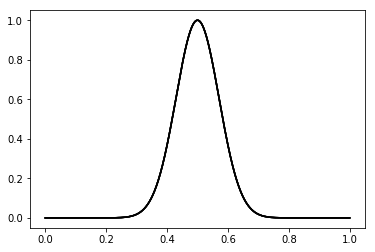

In [22]:
for j in range(0, 500, 50):
    plt.plot(xc, u[j, 1:-1], c='k', alpha=0.5)